In [1]:
from glob import glob
import os
import torch

def get_model_name(path: str) -> str:
  return os.path.splitext(os.path.basename(path))[0]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
models = {get_model_name(p): torch.load(p, "cpu") for p in glob("TrainingResults/*.pt")}
for model in models.values():
  for p in model.parameters():
    p.requires_grad = False
  model.eval()
  model.to(device)


In [2]:
sorted(models.keys())

['densenet_pretrained',
 'resnet18_pretrained',
 'resnext50_32x4d_pretrained',
 'squeezenet_pretrained',
 'wide_resnet50_2_pretrained']

In [3]:
import numpy as np
import time
import torch.nn as nn
import torch.nn.functional as F
import warnings
from PIL import Image
from termcolor import colored
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder


class_names = ['covid','non']

############### loading new images
imsize= 224
data_transforms = transforms.Compose([transforms.Resize(1024),
                              transforms.CenterCrop(512),
                              transforms.Resize(224),
                              transforms.ToTensor(),
                              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                             ])

sm = torch.nn.Softmax()

############### Get the predicted probabilities of all samples

def test_model(name, model, loader):
  start_time = time.time()
  Y_pred, Y_test = [], []
  warnings.filterwarnings("ignore")

  for i, (images, target) in enumerate(loader):
    images = images.to(device)
    model_start = time.time()
    outputs = model(images)
    model_time = time.time() - model_start
    outputs = outputs.cpu().detach()

    Y_pred.append(outputs)
    Y_test.append(target)

  y_pred = torch.cat(Y_pred)
  y_test = torch.cat(Y_test)
  covid_count = y_test.argmax()

  covid_prob = sm(y_pred[:covid_count, :])[:, 0]
  non_prob   = sm(y_pred[covid_count:, :])[:, 0]
  end_time= time.time()
  tot_time= end_time- start_time
  print(f"Tested {name} in {tot_time:.3f}s")

  return covid_prob, non_prob

In [4]:
batch_size = 20

test_data_path = 'data/test'
test_folder = ImageFolder(test_data_path, data_transforms)
test_loader = DataLoader(test_folder, batch_size=batch_size)

test_covid_prob, test_non_prob = {}, {}
for modelname, model in models.items():
  test_covid_prob[modelname], test_non_prob[modelname] = test_model(modelname, model, test_loader)
  

Tested resnet18_pretrained in 56.831s
Tested squeezenet_pretrained in 56.359s
Tested densenet_pretrained in 76.169s
Tested resnext50_32x4d_pretrained in 68.778s
Tested wide_resnet50_2_pretrained in 74.572s


In [5]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn


thresh = 0.2

############### derive labels based on probabilities and cut-off threshold

def plot_confusion_matrix(ax, name, covid_prob, non_prob):
  y_pred = torch.cat([covid_prob > thresh, non_prob > thresh]).int()
  y_test = torch.cat([torch.ones(len(covid_prob)), torch.zeros(len(non_prob))]).int()

  cnf_matrix = confusion_matrix(y_test, y_pred)
  np.set_printoptions(precision=2)   

  # Plot normalized confusion matrix

  df_cm = pd.DataFrame(cnf_matrix, index = [i for i in class_names],
                                  columns = [i for i in class_names])

  hm = sn.heatmap(df_cm, cmap=plt.cm.Blues, annot=True, cbar=False, fmt='g', xticklabels= ['Pred Non-COVID','Pred COVID-2019'], yticklabels= ['True Non-COVID','True COVID-2019'], ax=ax)
  hm.set_title(name)



In [6]:
from matplotlib.transforms import Bbox

def full_extent(ax, pad=0.0):
    """Get the full extent of an axes, including axes labels, tick labels, and
    titles."""
    # For text objects, we need to draw the figure first, otherwise the extents
    # are undefined.
    ax.figure.canvas.draw()
    items = ax.get_xticklabels() + ax.get_yticklabels() 
    items += [ax, ax.title]
    bbox = Bbox.union([item.get_window_extent() for item in items])

    return bbox.expanded(1.0 + pad, 1.0 + pad)


def save_ax(fig, ax, filename):
    # https://stackoverflow.com/questions/4325733/save-a-subplot-in-matplotlib
    # Save just the portion _inside_ the second axis's boundaries
    extent = full_extent(ax).transformed(fig.dpi_scale_trans.inverted())
    # Alternatively,
    # extent = ax.get_tightbbox(fig.canvas.renderer).transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, bbox_inches=extent)

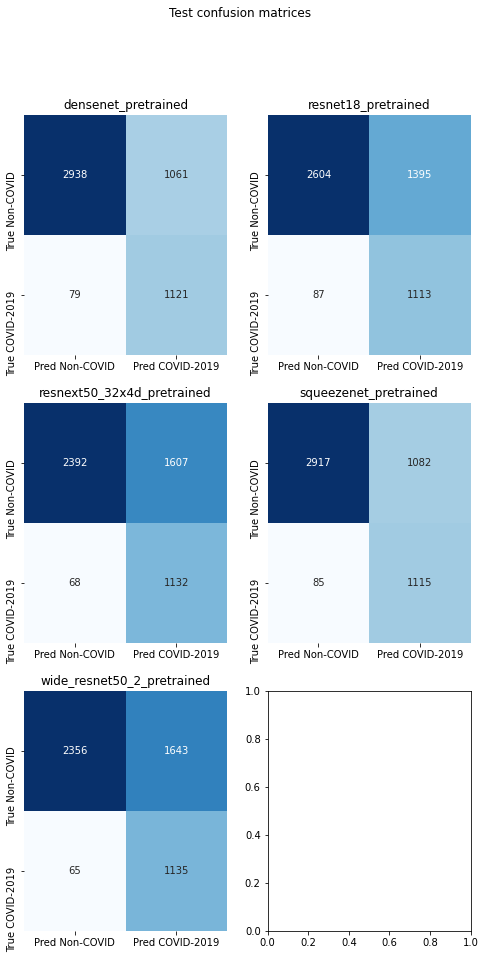

In [7]:
NUM_OF_COLS = 2
NUM_OF_ROWS = (len(models) + NUM_OF_COLS - 1) // NUM_OF_COLS
fig, subplots = plt.subplots(NUM_OF_ROWS, NUM_OF_COLS, figsize=(4*NUM_OF_COLS, 5*NUM_OF_ROWS))
fig.suptitle("Test confusion matrices")
for model_name, ax in zip(sorted(models.keys()), (col for row in subplots for col in row)):
    plot_confusion_matrix(ax, model_name, test_covid_prob[model_name], test_non_prob[model_name])
    save_ax(fig, ax, f"{model_name}_cm.png")    

In [25]:
############### ROC Curve and AUC
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

def plot_roc_curve(model_name, covid_prob, non_prob):
    y_test = torch.cat([torch.ones(len(covid_prob)), torch.zeros(len(non_prob))])
    y_pred = torch.cat([covid_prob, non_prob])
            
    auc = roc_auc_score(y_test, y_pred)
    ns_fpr, ns_tpr, _ = roc_curve(y_test, y_pred)

    plt.plot(ns_fpr, ns_tpr, linewidth=2, label=f"{model_name}\nAUC={auc:.3f}")
    plt.ylim([0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend(loc='lower right')


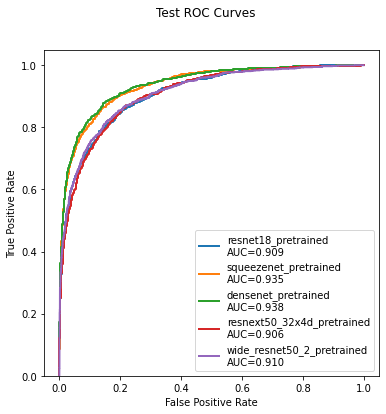

In [26]:
fig = plt.figure(figsize=[6, 6])
fig.suptitle("Test ROC Curves")
for model_name in models.keys():
    plot_roc_curve(model_name, test_covid_prob[model_name], test_non_prob[model_name])
    plt.savefig("test_roc.png")

In [27]:
from sklearn.metrics import precision_score, accuracy_score, f1_score, recall_score
import pandas as pd
import matplotlib.table
import seaborn as sn


thresh = 0.36

############### derive labels based on probabilities and cut-off threshold

def print_scores(dataset_name, covid_probs, non_probs):
    cell_text = []
    
    model_names = sorted(covid_probs.keys())
    for model_name in model_names:
        covid_prob = covid_probs[model_name]
        non_prob = non_probs[model_name]

        covid_pred = (covid_prob > thresh).int()
        covid_true = torch.ones(len(covid_prob))

        non_pred = (non_prob > thresh).int()
        non_true = torch.zeros(len(non_prob))

        sensitivity = recall_score(covid_true, covid_pred)
        specificity = recall_score(1-non_true, 1-non_pred)

        y_pred = torch.cat([covid_pred, non_pred])
        y_true = torch.cat([covid_true, non_true])

        precision = precision_score(y_true, y_pred)
        accuracy = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
    
        cell_text.append([f"{n:.3f}" for n in [sensitivity, specificity, precision, accuracy, f1]])

    fig, ax = plt.subplots(figsize=(10, 10))
    fig.patch.set_visible(False)
    ax.axis('off')
    ax.axis('tight')

    col_labels = ["Sensitivity", "Specificity", "Precision", "Accuracy", "F1"]
    table = matplotlib.table.table(ax=ax, cellText=cell_text, rowLabels=model_names, colLabels=col_labels, loc="center")
    table.scale(1,3)
    table.set_fontsize(20)

    return cell_text

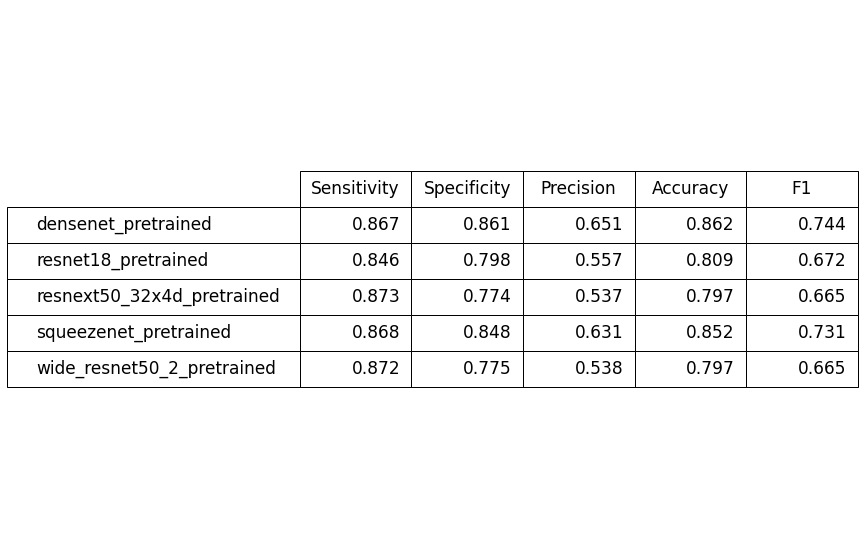

In [28]:
cell_text = print_scores("Testing", test_covid_prob, test_non_prob)

In [ ]:
for row in cell_text:
    print(",".join(row))

In [ ]:
def plot_probabilities(model_name, covid_prob, non_prob):
    fig, axs = plt.subplots(2)
    bins = np.linspace(0, 1, 25)
    fig.suptitle(model_name)
    
    axs[0].hist(covid_prob, bins, color='blue', histtype = 'bar', label='Probabilities of COVID-19 Samples')
    axs[0].legend(loc='upper center')
    axs[1].hist(non_prob, bins, color='green', label='Probabilities of Non-COVID Samples')
    axs[1].legend(loc='upper center')
    plt.savefig(f'{model_name}_probabilities.png')

In [29]:
plot_probabilities("densenet_pretrained", test_covid_prob["resnet18_pretrained"].tolist(), test_non_prob["resnet18_pretrained"].tolist())

NameError: name 'plot_probabilities' is not defined

In [ ]:
plot_probabilities("squeezenet_pretrained", test_covid_prob["resnext50_32x4d_pretrained"].tolist(), test_non_prob["resnext50_32x4d_pretrained"].tolist())